In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForImageClassification, AutoProcessor, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from src.gradient_rollout import AttentionGradRollout
from src.influence import Influence
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])
from src.perturbation import perturb_image

In [4]:
device = 'cuda'

# Attention Rollout

## ImageNet

In [45]:
train_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=200, seed=1)

# test_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'test')

Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Data/zh-plus___tiny-imagenet/default/0.0.0/5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Mon Feb 10 10:12:05 2025).


In [6]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [19]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [60]:
model = AutoModelForImageClassification.from_pretrained(
    "tzhao3/vit-tiny-imagenet", 
    attn_implementation = 'eager', 
    cache_dir = '/Data'
)\
    .to(device)
processor = AutoProcessor.from_pretrained("tzhao3/vit-tiny-imagenet")


In [30]:
batch_size = 1
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

In [46]:
metric = AttentionRollout(model, attention_layer_name='attention')

In [48]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, processor)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:14<00:00, 14.15it/s]


Removed 0.0 best tokens. Accuracy = 0.969072163105011


100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


Removed 0.1 best tokens. Accuracy = 0.8969072103500366


100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


Removed 0.2 best tokens. Accuracy = 0.8195876479148865


100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.7164948582649231


100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


Removed 0.4 best tokens. Accuracy = 0.5360824465751648


100%|██████████| 200/200 [00:14<00:00, 13.87it/s]


Removed 0.5 best tokens. Accuracy = 0.3505154550075531


100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.22680412232875824


100%|██████████| 200/200 [00:14<00:00, 13.79it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.13917525112628937


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


Removed 0.8 best tokens. Accuracy = 0.10309278219938278


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]

Removed 0.9 best tokens. Accuracy = 0.07216494530439377


In [50]:
pd.Series(accs)\
    .to_pickle("data/results/vit_attn_rollout_perturbation_positive.pkl")

## Gradient attention rollout

In [68]:
metric = AttentionGradRollout(model, attention_layer_name='attention.dropout')

In [69]:
attn_matrix.shape

(14, 14)

In [70]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
            tokens['labels'] = torch.tensor(row['label'])
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, processor)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/200 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 200/200 [00:14<00:00, 14.09it/s]


Removed 0.0 best tokens. Accuracy = 0.969072163105011


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


Removed 0.1 best tokens. Accuracy = 0.8865979313850403


100%|██████████| 200/200 [00:14<00:00, 13.50it/s]


Removed 0.2 best tokens. Accuracy = 0.7422680258750916


100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.5412371158599854


100%|██████████| 200/200 [00:15<00:00, 13.33it/s]


Removed 0.4 best tokens. Accuracy = 0.3659793734550476


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


Removed 0.5 best tokens. Accuracy = 0.21134020388126373


100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.18041236698627472


100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.09278350323438644


100%|██████████| 200/200 [00:15<00:00, 12.83it/s]


Removed 0.8 best tokens. Accuracy = 0.07216494530439377


100%|██████████| 200/200 [00:17<00:00, 11.28it/s]


Removed 0.9 best tokens. Accuracy = 0.0670103058218956


In [71]:
pd.Series(accs)\
    .to_pickle("data/results/vit_grad_rollout_perturbation_positive.pkl")

## Influence 

In [79]:
metric = Influence(model, discard_ratio=0.9, is_vit=True, return_mask=False)

In [80]:
attn_matrix.shape

torch.Size([1, 197, 197])

In [84]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue

        attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, processor)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/200 [00:00<?, ?it/s]/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 200/200 [00:09<00:00, 21.28it/s]


Removed 0.0 best tokens. Accuracy = 0.969072163105011


100%|██████████| 200/200 [00:09<00:00, 21.25it/s]


Removed 0.1 best tokens. Accuracy = 0.9020618796348572


100%|██████████| 200/200 [00:09<00:00, 20.90it/s]


Removed 0.2 best tokens. Accuracy = 0.7680412530899048


100%|██████████| 200/200 [00:09<00:00, 20.94it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.6443299055099487


100%|██████████| 200/200 [00:09<00:00, 20.63it/s]


Removed 0.4 best tokens. Accuracy = 0.4536082446575165


100%|██████████| 200/200 [00:09<00:00, 20.64it/s]


Removed 0.5 best tokens. Accuracy = 0.3144329786300659


100%|██████████| 200/200 [00:09<00:00, 20.40it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.21134020388126373


100%|██████████| 200/200 [00:09<00:00, 20.41it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.13917525112628937


100%|██████████| 200/200 [00:09<00:00, 20.05it/s]


Removed 0.8 best tokens. Accuracy = 0.0824742242693901


100%|██████████| 200/200 [00:10<00:00, 19.94it/s]

Removed 0.9 best tokens. Accuracy = 0.0824742242693901


In [85]:
pd.Series(accs)\
    .to_pickle("data/results/vit_influence_perturbation_positive.pkl")

## Final plot

attn_rollout - AUC = 0.43092783279716973
influence - AUC = 0.4041237134486437
grad_rollout - AUC = 0.3610824700444937


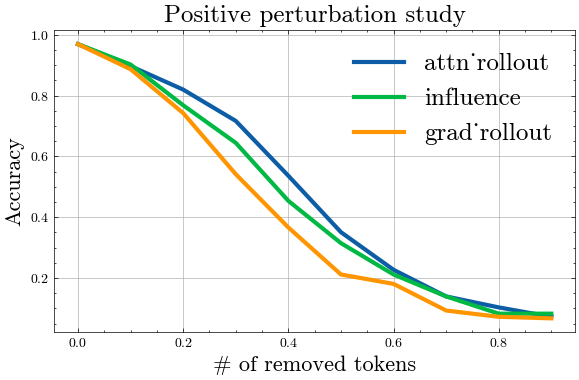

In [86]:
metrics = ['attn_rollout','influence', 'grad_rollout']

plt.figure(figsize=(6,4))
for metric in metrics:
    x = pd.read_pickle(f"data/results/vit_{metric}_perturbation_positive.pkl")
    auc = np.trapz(x.values, x.index)

    print(f"{metric} - AUC = {auc}")
    plt.plot(x, label = metric, linewidth = 3)

plt.grid()
plt.title("Positive perturbation study", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 16)
plt.xlabel("# of removed tokens", fontsize = 16)
plt.legend(fontsize = 18)
plt.tight_layout()